# Softmax分类

Softmax中的硬性类别与软类别。

对于分类问题，我们往往只对样本的硬件类别感兴趣，即属于哪个类别；但同时，我们希望得到软性类别，即属于第个类别的概率。这两者界限往往很模糊。其中的一个原因是，即使我们只关心硬类别，我们仍然使用软类别的模型。

# 如何表示类别

我们有两个明显的选择。也许最直接的想法是选择$y\in \{1,2,3\}$，其中整数分别代表  {狗,猫,鸡} 。这是在计算机上存储此类信息的好方法。如果类别间有一些自然顺序，比如说我们试图预测  {婴儿,儿童,青少年,青年人,中年人,老年人} ，那么将这个问题转变为回归问题并保留这种格式是有意义的。

但是，一般的分类问题并不与类别之间的自然顺序有关。幸运的是，统计学家很早以前就发明了一种表示分类数据的简单方法：独热编码（one-hot encoding）。独热编码是一个向量，它的分量和类别一样多。类别对应的分量设置为1，其他所有分量设置为0。 在我们的例子中，标签$\mathbf{y}$将是一个三维向量，其中$(1,0,0)$对应于 “猫”、$(0,1,0)$对应于 “鸡”、$(0,0,1)$对应于 “狗”：
$$y\in\{(1,0,0),(0,1,0),(0,0,1)\}$$

In [1]:
import torch

样本的数量为$N$，特征长度为$D$，分类的类别为$K$，那么

- 输入数据为$X$，是一个$N\times D$的矩阵
- 参数$W$是一个为$D\times K$的矩阵
- 参数$\mathbf{b}$是一个长度为$K$的向量。
- 参考输出$\mathbf{Y}$是一个$N\times K$的矩阵，矩阵每一行为一个样本的输出，如果样本$i$属于第$k$类，则$Y_{i,k} = 1$，这一行的其他元素全为0。

$$
\begin{align}
Z &= X\cdot W + \mathbf{b} \\
\hat{Y} &= \frac{e^{Z}}{\sum_ke^{Z_{:,k}}} \\
L(W,\mathbf{b}) &= \frac{1}{N}\sum(-Y\circ\ln \hat{Y}),\;\circ\text{代表按元素乘}
\end{align}
$$

In [2]:
class SoftmaxRegression(object):
    def __init__(self, num_features, num_classes):
        # 这里对于w的初始化的值，是非常影响模型的训练速度与效果的
        self.w = torch.normal(
            0, 0.01, (num_features, num_classes), requires_grad=True)
        self.b = torch.zeros(num_classes, requires_grad=True)

    def forward(self, x):
        x = x.reshape((-1, self.w.shape[0]))  # 将x从1x28x28转化为28x28
        z = torch.matmul(x, self.w) + self.b
        z -= torch.max(z, dim=1, keepdim=True)[0]  # 消除特别大的值
        exp_z = torch.exp(z)
        return exp_z / torch.sum(exp_z, dim=1, keepdim=True)

    def parameters(self):
        return self.w, self.b

    def __call__(self, x):
        return self.forward(x)

In [3]:
'''
Args:
  y_hat: 是一个N*K的矩阵，每一行代表对应样本预测的每一类的概率
  y:是一个N*1的向量，向量每个值，代表该样本属于哪一个类别
'''


def CrossEntropy(y_hat, y):
    return torch.mean(-torch.log(y_hat[range(len(y)), y]))

# Fashion MNist数据集

MNist共有10个类别，每个类别有6000张测试集和1000张测试集，图片的大小为28x28

In [4]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [5]:
training_set = datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=ToTensor())
testing_set = datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=ToTensor())
print(f'training dataset size: {len(training_set)}')
print(f'testing dataset size: {len(testing_set)}')
print(f'image size: {training_set[0][0].shape}')

training dataset size: 60000
testing dataset size: 10000
image size: torch.Size([1, 28, 28])


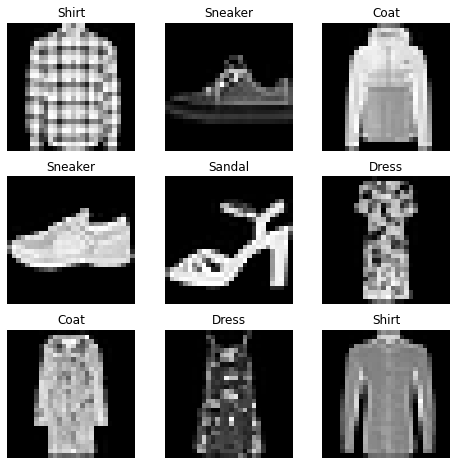

In [6]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(cols * rows):
    # 随机选择一个样本
    sample_idx = torch.randint(len(training_set), size=(1,)).item()
    img, label = training_set[sample_idx]
    figure.add_subplot(rows, cols, i + 1)
    plt.title(labels_map[label])
    plt.axis("off")  # 不显示x,y坐标轴上的刻度
    plt.imshow(img.squeeze(), cmap="gray")  # img默认是1x28x28的，squeeze后变成28x28
plt.show()

In [7]:
batch_size = 256
training_iter = torch.utils.data.DataLoader(
    training_set, batch_size, shuffle=True)
testing_iter = torch.utils.data.DataLoader(testing_set, batch_size)

# 从零实现

In [8]:
def optimizer_scg(parameters, lr=0.03):
    with torch.no_grad():
        for param in parameters:
            param -= lr * param.grad
            param.grad.zero_()

In [9]:
def accuracy(y_hat, y):
    max_indices = torch.max(y_hat, dim=1)[1]
    return (y == max_indices).to(dtype=torch.float32).mean()


def accuracy_on(model, data_iter):
    acc = []
    for X, y in data_iter:
        y_hat = model(X)
        acc.append(accuracy(y_hat, y))
    return torch.tensor(acc).mean().item()

the loss of epoch 0: 0.7820, accuracy on training set: 0.7526, accuracy on testing set: 0.7893
the loss of epoch 1: 0.5706, accuracy on training set: 0.8133, accuracy on testing set: 0.8129
the loss of epoch 2: 0.5258, accuracy on training set: 0.8251, accuracy on testing set: 0.7807
the loss of epoch 3: 0.5025, accuracy on training set: 0.8310, accuracy on testing set: 0.8145
the loss of epoch 4: 0.4851, accuracy on training set: 0.8372, accuracy on testing set: 0.8257
the loss of epoch 5: 0.4735, accuracy on training set: 0.8403, accuracy on testing set: 0.8314
the loss of epoch 6: 0.4645, accuracy on training set: 0.8430, accuracy on testing set: 0.8304
the loss of epoch 7: 0.4576, accuracy on training set: 0.8446, accuracy on testing set: 0.8323
the loss of epoch 8: 0.4525, accuracy on training set: 0.8468, accuracy on testing set: 0.8270
the loss of epoch 9: 0.4478, accuracy on training set: 0.8485, accuracy on testing set: 0.8288


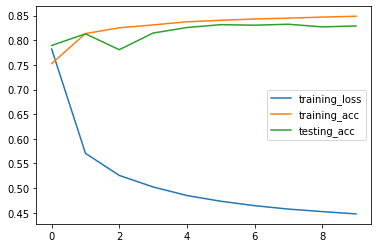

In [10]:
num_features = 28 * 28
num_classes = 10
model = SoftmaxRegression(num_features, num_classes)

epoch = 10
lr = 0.1
training_loss = []
training_acc = []
testing_acc = []
for i in range(epoch):
    epoch_loss = 0
    epoch_accuracy = 0
    for X, y in training_iter:
        y_hat = model(X)
        loss = CrossEntropy(y_hat, y)
        epoch_accuracy += accuracy(y_hat, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer_scg(model.parameters(), lr)
    training_loss.append(epoch_loss / len(training_iter))
    training_acc.append(epoch_accuracy / len(training_iter))
    testing_acc.append(accuracy_on(model, testing_iter))
    print(
        f'the loss of epoch {i}: {training_loss[-1]:.4f}, accuracy on training set: {training_acc[-1]:.4f}, accuracy on testing set: {testing_acc[-1]:.4f}')
plt.plot(training_loss, label='training_loss')
plt.plot(training_acc, label='training_acc')
plt.plot(testing_acc, label='testing_acc')
plt.legend()
plt.show()

# Pytorch简洁版本实现

the loss of epoch 0: 0.7841, accuracy on training set: 0.8485, accuracy on testing set: 0.7854
the loss of epoch 1: 0.5711, accuracy on training set: 0.8485, accuracy on testing set: 0.7830
the loss of epoch 2: 0.5250, accuracy on training set: 0.8485, accuracy on testing set: 0.8108
the loss of epoch 3: 0.5016, accuracy on training set: 0.8485, accuracy on testing set: 0.8094
the loss of epoch 4: 0.4860, accuracy on training set: 0.8485, accuracy on testing set: 0.8195
the loss of epoch 5: 0.4739, accuracy on training set: 0.8485, accuracy on testing set: 0.8286
the loss of epoch 6: 0.4646, accuracy on training set: 0.8485, accuracy on testing set: 0.8289
the loss of epoch 7: 0.4573, accuracy on training set: 0.8485, accuracy on testing set: 0.8282
the loss of epoch 8: 0.4520, accuracy on training set: 0.8485, accuracy on testing set: 0.8253
the loss of epoch 9: 0.4473, accuracy on training set: 0.8485, accuracy on testing set: 0.8265


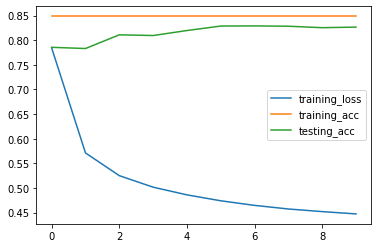

In [12]:
model = nn.Sequential(nn.Flatten(), nn.Linear(num_features, num_classes))


def init_weigth(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)


model.apply(init_weigth)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

epoch = 10
training_loss = []
training_acc = []
testing_acc = []
for i in range(epoch):
    epoch_loss = 0
    epoch_acc = 0
    for X, y in training_iter:
        y_hat = model(X)
        l = loss(y_hat, y)
        epoch_loss += l.item()
        epoch_acc += accuracy(y_hat, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    training_loss.append(epoch_loss / len(training_iter))
    training_acc.append(epoch_accuracy / len(training_iter))
    testing_acc.append(accuracy_on(model, testing_iter))
    print(
        f'the loss of epoch {i}: {training_loss[-1]:.4f}, accuracy on training set: {training_acc[-1]:.4f}, accuracy on testing set: {testing_acc[-1]:.4f}')
plt.plot(training_loss, label='training_loss')
plt.plot(training_acc, label='training_acc')
plt.plot(testing_acc, label='testing_acc')
plt.legend()
plt.show()